In [4]:
%load_ext autoreload
%autoreload 2

import math 
import warnings
import numpy as np
import matplotlib.pyplot as plt

from alexander_nikulin_v2 import *
from tqdm import trange

warnings.filterwarnings('ignore')

def expectation(prob, val):
    return np.dot(prob, val)

def variance(prob, val):
    return expectation(prob, val**2) - expectation(prob, val)**2

def arithmetic_round(n):
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# конфиг для 2 варианта
params = {
    "amin": 75,
    "amax": 90,
    "bmin": 500,
    "bmax": 600,
    "p1": 0.1,
    "p2": 0.01,
    "p3": 0.3
}
a = np.arange(params["amin"], params["amax"] + 1)
b = np.arange(params["bmin"], params["bmax"] + 1)
c = np.arange(params["amax"] + params["bmax"] + 1)
d = np.arange(2 * (params["amax"] + params["bmax"]) + 1)

### 0. Тесты

In [3]:
!python BMML1_open_tests.py

pa, model 1: 	 ok; 	 time: 0.0000 seconds
pa, model 2: 	 ok; 	 time: 0.0000 seconds
pb, model 1: 	 ok; 	 time: 0.0000 seconds
pb, model 2: 	 ok; 	 time: 0.0000 seconds
pc, model 1: 	 ok; 	 time: 0.5452 seconds
pc, model 2: 	 ok; 	 time: 0.0350 seconds
pd, model 1: 	 ok; 	 time: 0.6475 seconds
pd, model 2: 	 ok; 	 time: 0.1549 seconds
pc_a, model 1: 	 ok; 	 time: 0.0578 seconds
pc_a, model 2: 	 ok; 	 time: 0.0027 seconds
pc_b, model 1: 	 ok; 	 time: 0.0092 seconds
pc_b, model 2: 	 ok; 	 time: 0.0005 seconds
pb_a, model 1: 	 ok; 	 time: 0.0000 seconds
pb_a, model 2: 	 ok; 	 time: 0.0000 seconds
pb_d, model 1: 	 ok; 	 time: 0.6353 seconds
pb_d, model 2: 	 ok; 	 time: 0.1569 seconds
pb_ad, model 1: 	 ok; 	 time: 0.1738 seconds
pb_ad, model 2: 	 ok; 	 time: 0.1185 seconds


### 2. Найти математические ожидания и дисперсии априорных распределений p(a), p(b), p(c), p(d)

In [4]:
for model in [1, 2]:
    print("Model:", model)
    mean_a = arithmetic_round(expectation(*pa(params, model)))
    mean_b = arithmetic_round(expectation(*pb(params, model)))
    mean_c = arithmetic_round(expectation(*pc(params, model)))
    mean_d = arithmetic_round(expectation(*pd(params, model)))
    
    var_a = arithmetic_round(variance(*pa(params, model)))
    var_b = arithmetic_round(variance(*pb(params, model)))
    var_c = arithmetic_round(variance(*pc(params, model)))
    var_d = arithmetic_round(variance(*pd(params, model)))

    print("p(a):", mean_a, var_a)
    print("p(b):", mean_b, var_b)
    print("p(c):", mean_c, var_c)
    print("p(d):", mean_d, var_d)

Model: 1
p(a): 83 21
p(b): 550 850
p(c): 14 13
p(d): 18 25
Model: 2
p(a): 83 21
p(b): 550 850
p(c): 14 14
p(d): 18 27


### 3. Пронаблюдать, как происходит уточнение прогноза для величины b по мере прихода новой косвенной информации.
Для этого построить графики и найти мат.ожидание и дисперсию для распределений p(b),
p(b|a), p(b|d), p(b|a, d) при параметрах a, d, равных мат.ожиданиям своих априорных распределений

Model 1, E p(b | d): 550.0726755897829
Model 1, Var p(b | d): 848.037891839107
Model 1, E p(b | a, d): 550.0363468930655
Model 1, Var p(b | a, d): 848.0311255462002
Model 2, E p(b | d): 550.0977797601524
Model 2, Var p(b | d): 848.128027453844
Model 2, E p(b | a, d): 550.0634796135496
Model 2, Var p(b | a, d): 848.1231120710727


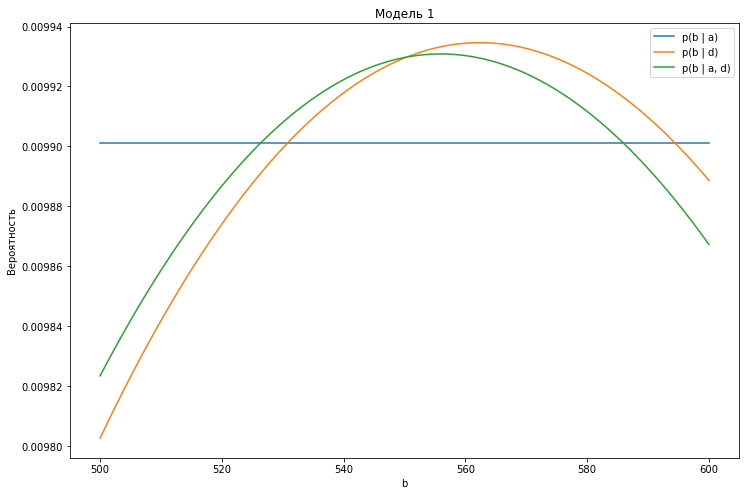

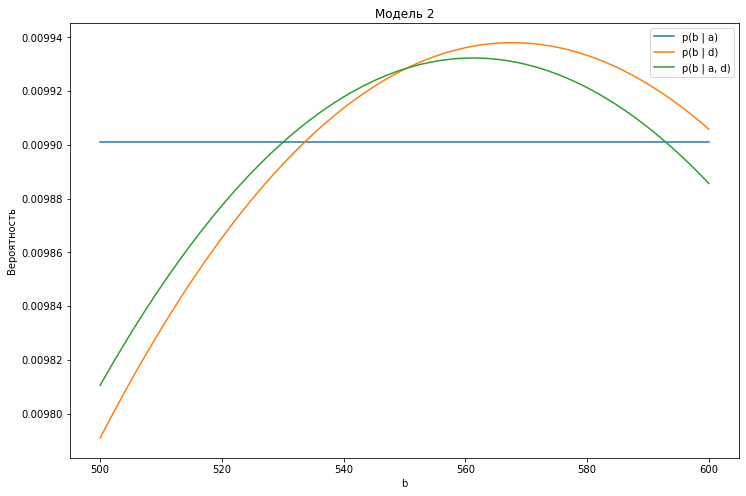

In [9]:
for model in [1, 2]:
    mean_a = arithmetic_round(expectation(*pa(params, model)))
    mean_d = arithmetic_round(expectation(*pd(params, model)))

    dist_pb, values = pb(params, model)
    dist_pb_a, values = pb_a(np.array([mean_a]), params, model)
    dist_pb_d, values = pb_d(np.array([mean_d]), params, model)
    dist_pb_ad, values = pb_ad(np.array([mean_a]), np.array([mean_d]), params, model)

    assert np.allclose(dist_pb_d.sum(), 1.0)
    assert np.allclose(dist_pb_ad.sum(), 1.0)
    
    print(f"Model {model}, E p(b | d):", expectation(dist_pb_d.flatten(), values))
    print(f"Model {model}, Var p(b | d):", variance(dist_pb_d.flatten(), values))
    print(f"Model {model}, E p(b | a, d):", expectation(dist_pb_ad.flatten(), values))
    print(f"Model {model}, Var p(b | a, d):", variance(dist_pb_ad.flatten(), values))
    
    plt.figure(figsize=(12, 8))
    plt.plot(values, dist_pb_a, label="p(b | a)")
    plt.plot(values, dist_pb_d, label="p(b | d)")
    plt.plot(values, dist_pb_ad.flatten(), label="p(b | a, d)")
    plt.title(f"Модель {model}")
    plt.xlabel("b")
    plt.ylabel("Вероятность")
    plt.legend()

### 4. Определить, при каких соотношениях параметров p 1 , p 2 изменяется относительная важность параметров a, b для оценки величины c.

In [11]:
pparams = params.copy()

mean_a = arithmetic_round(expectation(*pa(params, 1)))
mean_b = arithmetic_round(expectation(*pb(params, 1)))

p1, p2 = np.linspace(0, 1, 100), np.linspace(0, 1, 100)

res_mask1 = np.zeros((100, 100))
res_mask2 = np.zeros((100, 100))

for i in trange(100):
    for j in range(100):
        pparams["p1"] = p1[i]
        pparams["p2"] = p2[j]
        
        dist_pc_a, val_pc_a = pc_a(np.array([mean_a]), pparams, 1) 
        dist_pc_b, val_pc_b = pc_b(np.array([mean_b]), pparams, 1)
        
        var_pc_a = variance(dist_pc_a.flatten(), val_pc_a)
        var_pc_b = variance(dist_pc_b.flatten(), val_pc_b)
        
        res_mask1[i, j] = var_pc_b < var_pc_a
        res_mask2[i, j] = var_pc_b >= var_pc_a

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:00<00:00,  7.81s/it]


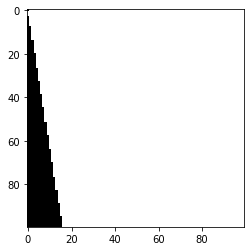

In [12]:
plt.imshow(res_mask1, cmap="gray", interpolation="none")

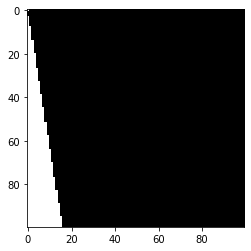

In [13]:
plt.imshow(res_mask2, cmap="gray", interpolation="none")

### 5. Провести временные замеры по оценке всех необходимых распределений p(c), p(c|a), p(c|b), p(b|a), p(b|d), p(b|a, d), p(d)

#### Модель 1

In [6]:
%%timeit
pc(params, model=1);

531 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
pc_a(a, params, model=1)

531 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
pc_b(b, params, model=1)

529 ms ± 6.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
pb_a(a, params, model=1)

3.62 µs ± 149 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%%timeit
pb_d(d, params, model=1)

812 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
pb_ad(a, d, params, model=1)

3.81 s ± 37.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
pd(params, model=1)

690 ms ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Модель 2

In [13]:
%%timeit
pc(params, model=2)

31 ms ± 459 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit
pc_a(a, params, model=2)

31.9 ms ± 581 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%%timeit
pc_b(b, params, model=2)

31.8 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%timeit
pb_a(a, params, model=2)

3.72 µs ± 307 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [17]:
%%timeit
pb_d(d, params, model=2)

281 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
pb_ad(a, d, params, model=2)

3.44 s ± 85.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit
pd(params, model=2)

149 ms ± 4.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
